In [1]:
import ROOT, math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import norm

Welcome to JupyROOT 6.30/06


In [2]:
# FileMBGen  = ROOT.TFile("Input/MinBiasMC_Gen_Sample.root")
# FileMBReco = ROOT.TFile("Input/MinBiasMC_Reco_Sample.root")
# FileDYGen  = ROOT.TFile("Input/DYLLMC_Gen_Sample.root")
# FileDYReco = ROOT.TFile("Input/DYLLMC_Reco_Sample.root")
# FilePPGen  = ROOT.TFile("Input/PPMC_Gen_Sample.root")
# FilePPReco = ROOT.TFile("Input/PPMC_Reco_Sample.root")

FileMBGen  = ROOT.TFile("Input/MinBiasMC_Gen.root")
FileMBReco = ROOT.TFile("Input/MinBiasMC_Reco.root")
FileDYGen  = ROOT.TFile("Input/DYLLMC_Gen.root")
FileDYReco = ROOT.TFile("Input/DYLLMC_Reco.root")
FilePPGen  = ROOT.TFile("Input/PPMC_Gen.root")
FilePPReco = ROOT.TFile("Input/PPMC_Reco.root")

def CleanUp():
    FileMBGen.Close()
    FileMBReco.Close()
    FileDYGen.Close()
    FileDYReco.Close()
    FilePPGen.Close()
    FilePPReco.Close()

TreeMBGen  = FileMBGen.Get("Tree")
TreeMBReco = FileMBReco.Get("Tree")
TreeDYGen  = FileDYGen.Get("Tree")
TreeDYReco = FileDYReco.Get("Tree")
TreePPGen  = FilePPGen.Get("Tree")
TreePPReco = FilePPReco.Get("Tree")

# TreeMBReco.AddFriend(TreeDYReco, "TDY")


In [3]:
def DivideByBinWidth(H):
    N = H.GetNbinsX()
    for i in range(1, N + 1):
        L = H.GetXaxis().GetBinLowEdge(i)
        R = H.GetXaxis().GetBinUpEdge(i)
        H.SetBinContent(i, H.GetBinContent(i) / (R - L))
        H.SetBinError(i, H.GetBinError(i) / (R - L))
        
def Integral(H):
    N = H.GetNbinsX()
    V = 0
    E2 = 0
    for i in range(1, N + 1):
        L = H.GetXaxis().GetBinLowEdge(i)
        R = H.GetXaxis().GetBinUpEdge(i)
        V = V + H.GetBinContent(i) * (R - L)
        E2 = E2 + (H.GetBinError(i) * (R - L))**2
    return V

def TranscribeRecoWeightOld(FileName):
    File = ROOT.TFile(FileName)
    Hist = File.Get("HRatio")
    
    Result = "0"
    N = Hist.GetNbinsX()
    for i in range(1, N + 1):
        L = Hist.GetXaxis().GetBinLowEdge(i)
        R = Hist.GetXaxis().GetBinUpEdge(i)
        V = Hist.GetBinContent(i)
        if V == 0:
            continue
        Result = Result + f"+{V}*(SignalHF>={L}&&SignalHF<{R})"

    return "(" + Result + ")"

def TranscribeRecoWeight(FileName):
    File = ROOT.TFile(FileName)
    Hist = File.Get("HRatio")

    VPrevious = 0
    
    Result = "0"
    N = Hist.GetNbinsX()
    for i in range(1, N + 1):
        L = Hist.GetXaxis().GetBinLowEdge(i)
        R = Hist.GetXaxis().GetBinUpEdge(i)
        V = Hist.GetBinContent(i)
        if V == 0:
            VPrevious = V
            continue
        VDiff = V - VPrevious
        if VDiff != 0:
            Result = Result + f"+{VDiff}*(SignalHF>={L})"
        VPrevious = V

    return "(" + Result + ")"

In [4]:
TreeDYGen.SetAlias("GoodGenZ", "(genZPt[0] > 20 && genZY[0] < 2.4 && genZY[0] > -2.4 && genZMass[0] > 60 && genZMass[0] < 120)");
TreeDYReco.SetAlias("GoodRecoZ", "(zPt[0] > 20 && zY[0] < 2.4 && zY[0] > -2.4 && zMass[0] > 60 && zMass[0] < 120)");
TreePPGen.SetAlias("GoodGenZ", "(genZPt[0] > 20 && genZY[0] < 2.4 && genZY[0] > -2.4 && genZMass[0] > 60 && genZMass[0] < 120)");
TreePPReco.SetAlias("GoodRecoZ", "(zPt[0] > 20 && zY[0] < 2.4 && zY[0] > -2.4 && zMass[0] > 60 && zMass[0] < 120)");

TreeDYReco.SetAlias("RecoHFShift", "(763.1539360425459-101.2995115409047*exp(-0.09666472578946463*zPt[0])-82.36975543861207)")

TreeMBReco.SetAlias("RecoWeight010", TranscribeRecoWeight("RecoWeight_Centrality010.root"))
TreeMBReco.SetAlias("RecoWeight1030", TranscribeRecoWeight("RecoWeight_Centrality1030.root"))
TreeMBReco.SetAlias("RecoWeight1030Extra", TranscribeRecoWeight("RecoWeight_Centrality1030_ExtraShift.root"))
TreeMBReco.SetAlias("RecoWeight1030Extra2", TranscribeRecoWeight("RecoWeight_Centrality1030_ExtraShift2.root"))
TreeMBReco.SetAlias("RecoWeight030", TranscribeRecoWeight("RecoWeight_Centrality030_ReducedBin.root"));
TreeMBReco.SetAlias("RecoWeight030Scale", TranscribeRecoWeight("RecoWeight_Centrality030_Scale.root"));

In [5]:
Canvas = ROOT.TCanvas("Canvas", "")
HZCount = ROOT.TH1D("HZCount", ";;", 10, 1, 11)
MinPT = 1

Integral: MB = 474.91951227081915, DY = 487.3745010439336, PP = 14.30357848322341
First bin: MB = 60.4149969556949, DY = 62.65682210604932, PP = 2.4524915613175122


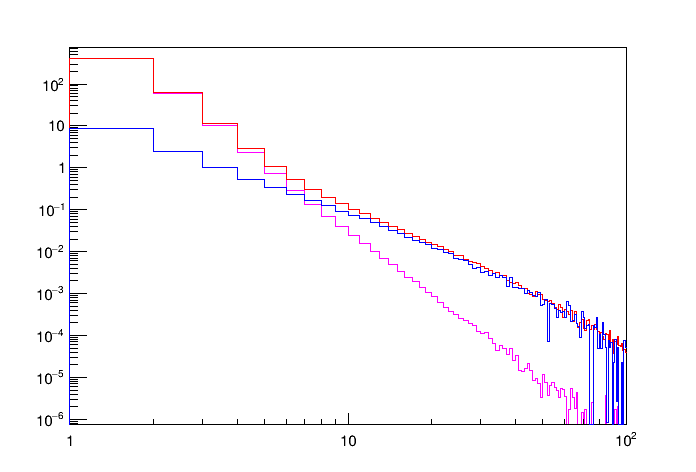

In [6]:
# First step: double check that we can get the full centrality numbers

HMBRecoPT  = ROOT.TH1D("HMBRecoPT", ";;", 100, 0, 100)
HDYRecoPT  = ROOT.TH1D("HDYRecoPT", ";;", 100, 0, 100)
HPPRecoPT  = ROOT.TH1D("HPPRecoPT", ";;", 100, 0, 100)

TreeMBReco.Draw("trackPt >> HMBRecoPT", f"EventWeight * ((trackPt >= {MinPT}) * (trackWeight))", "")
TreeMBReco.Draw("3 >> HZCount", "EventWeight", "")
HMBRecoPT.Scale(1 / HZCount.GetBinContent(3))
DivideByBinWidth(HMBRecoPT)
VMBFull = Integral(HMBRecoPT)

TreeDYReco.Draw("trackPt >> HDYRecoPT", f"ZWeight * EventWeight * ((trackPt >= {MinPT} && trackMuTagged == 0) * (trackWeight) * GoodRecoZ)", "")
TreeDYReco.Draw("2 >> HZCount", "ZWeight * EventWeight * GoodRecoZ", "")
HDYRecoPT.Scale(1 / HZCount.GetBinContent(2))
DivideByBinWidth(HDYRecoPT)
VDYFull = Integral(HDYRecoPT)

TreePPReco.Draw("trackPt >> HPPRecoPT", f"ZWeight * EventWeight * ((trackPt >= {MinPT} && trackMuTagged == 0 && NVertex == 1) * (trackWeight) * GoodRecoZ)", "")
TreePPReco.Draw("1 >> HZCount", "ZWeight * EventWeight * GoodRecoZ * (NVertex == 1)", "")
HPPRecoPT.Scale(1 / HZCount.GetBinContent(1))
DivideByBinWidth(HPPRecoPT)
VPP = Integral(HPPRecoPT)

HMBRecoPT.SetStats(0)

HPPRecoPT.SetLineColor(ROOT.kBlue)
HDYRecoPT.SetLineColor(ROOT.kRed)
HMBRecoPT.SetLineColor(ROOT.kMagenta)

HMBRecoPT.Draw("hist")
HDYRecoPT.Draw("hist same")
HPPRecoPT.Draw("hist same")
Canvas.SetLogx()
Canvas.SetLogy()
Canvas.Draw()

print(f"Integral: MB = {Integral(HMBRecoPT)}, DY = {Integral(HDYRecoPT)}, PP = {Integral(HPPRecoPT)}")
print(f"First bin: MB = {HMBRecoPT.GetBinContent(3)}, DY = {HDYRecoPT.GetBinContent(3)}, PP = {HPPRecoPT.GetBinContent(3)}")

In [41]:
print(HZCount.GetBinContent(1))

373871762.90106106


Integral: MB = 1217.139146958945, DY = 1228.2124404941662, PP = 14.30357848322341
First bin: MB = 156.38299782489742, DY = 158.49014563523664, PP = 2.4524915613175122


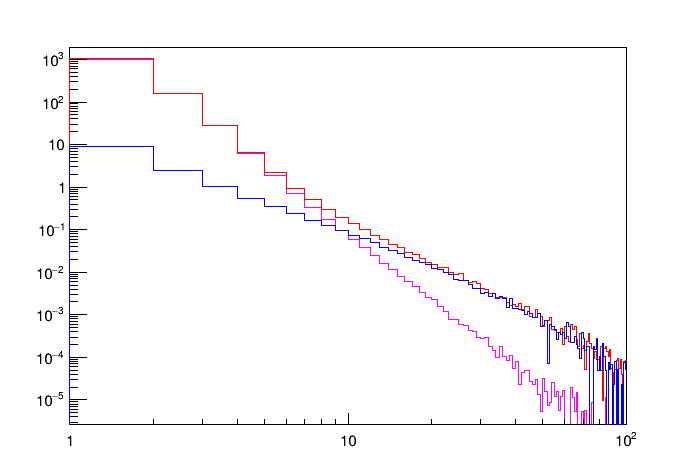

In [7]:
# Next step: double check that we can get the bugged centrality numbers -> not bugged anymore!

HMBRecoPTC030  = ROOT.TH1D("HMBRecoPTC030", ";;", 100, 0, 100)
HDYRecoPTC030  = ROOT.TH1D("HDYRecoPTC030", ";;", 100, 0, 100)

TreeMBReco.Draw("trackPt >> HMBRecoPTC030", f"EventWeight * ((trackPt >= {MinPT}) * (trackWeight) * RecoWeight030)", "")
TreeMBReco.Draw("3 >> HZCount", "EventWeight * RecoWeight030", "")
HMBRecoPTC030.Scale(1 / HZCount.GetBinContent(3))
DivideByBinWidth(HMBRecoPTC030)
VMBC030 = Integral(HMBRecoPTC030)

TreeDYReco.Draw("trackPt >> HDYRecoPTC030", f"ZWeight * EventWeight * ((trackPt >= {MinPT} && trackMuTagged == 0) * (trackWeight) * GoodRecoZ * (hiBin < 60))", "")
TreeDYReco.Draw("2 >> HZCount", "ZWeight * EventWeight * GoodRecoZ * (hiBin < 60)", "")
HDYRecoPTC030.Scale(1 / HZCount.GetBinContent(2))
DivideByBinWidth(HDYRecoPTC030)
VDYC030 = Integral(HDYRecoPTC030)

HMBRecoPTC030.SetStats(0)

HDYRecoPTC030.SetLineColor(ROOT.kRed)
HMBRecoPTC030.SetLineColor(ROOT.kMagenta)

HMBRecoPTC030.Draw("hist")
HDYRecoPTC030.Draw("hist same")
HPPRecoPT.Draw("hist same")
Canvas.SetLogx()
Canvas.SetLogy()
Canvas.Draw()

print(f"Integral: MB = {Integral(HMBRecoPTC030)}, DY = {Integral(HDYRecoPTC030)}, PP = {Integral(HPPRecoPT)}")
print(f"First bin: MB = {HMBRecoPTC030.GetBinContent(3)}, DY = {HDYRecoPTC030.GetBinContent(3)}, PP = {HPPRecoPT.GetBinContent(3)}")

Integral: MB = 184.30335773667568, DY = 189.6343972819938, PP = 5.403203418664888
First bin: MB = 149.2157057255993, DY = 151.5318701268304, PP = 2.4451144412603836


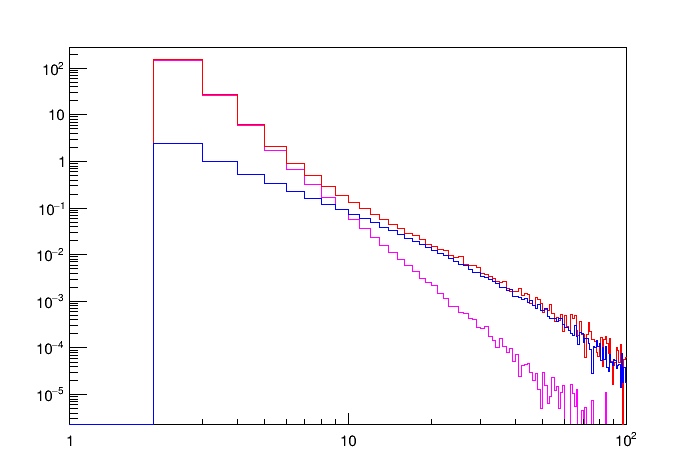

In [10]:
# Now time for hybrids

HMBRecoPTHybrid  = ROOT.TH1D("HMBRecoPTHybrid", ";;", 100, 0, 100)
HDYRecoPTHybrid  = ROOT.TH1D("HDYRecoPTHybrid", ";;", 100, 0, 100)

TreeMBReco.Draw("trackPt >> HMBRecoPTHybrid", f"EventWeight * ((trackPt >= {MinPT}) * (trackWeight) * (SubEventAllHF > 40000))", "")
TreeMBReco.Draw("3 >> HZCount", "EventWeight * (SubEventAllHF > 40000)", "")
HMBRecoPTHybrid.Scale(1 / HZCount.GetBinContent(3))
DivideByBinWidth(HMBRecoPTHybrid)
VMBHybrid = Integral(HMBRecoPTHybrid)

TreeDYReco.Draw("trackPt >> HDYRecoPTHybrid", f"ZWeight * EventWeight * ((trackPt >= {MinPT} && trackMuTagged == 0) * (trackWeight) * GoodRecoZ * (SubEventAllHF - SubEvent0HF > 40000))", "")
TreeDYReco.Draw("2 >> HZCount", "ZWeight * EventWeight * GoodRecoZ * (SubEventAllHF - SubEvent0HF > 40000)", "")
HDYRecoPTHybrid.Scale(1 / HZCount.GetBinContent(2))
DivideByBinWidth(HDYRecoPTHybrid)
VDYHybrid = Integral(HDYRecoPTHybrid)

HMBRecoPTHybrid.SetStats(0)

HDYRecoPTHybrid.SetLineColor(ROOT.kRed)
HMBRecoPTHybrid.SetLineColor(ROOT.kMagenta)

HMBRecoPTHybrid.Draw("hist")
HDYRecoPTHybrid.Draw("hist same")
HPPRecoPT.Draw("hist same")
Canvas.SetLogx()
Canvas.SetLogy()
Canvas.Draw()

print(f"Integral: MB = {Integral(HMBRecoPTHybrid)}, DY = {Integral(HDYRecoPTHybrid)}, PP = {Integral(HPPRecoPT)}")
print(f"First bin: MB = {HMBRecoPTHybrid.GetBinContent(3)}, DY = {HDYRecoPTHybrid.GetBinContent(3)}, PP = {HPPRecoPT.GetBinContent(3)}")

Integral: MB = 215.47705386870058, DY = 221.1786911757326, PP = 5.403203418664888
First bin: MB = 174.50868566092512, DY = 177.13983079766143, PP = 2.4451144412603836


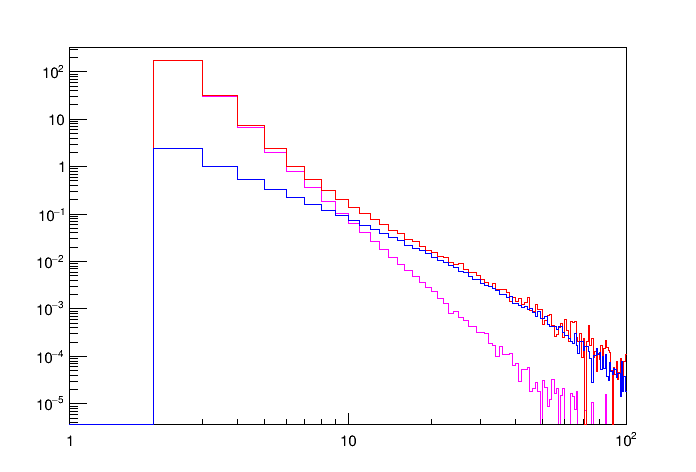

In [11]:
# Now time for another hybrid

HMBRecoPTHybrid2 = ROOT.TH1D("HMBRecoPTHybrid2", ";;", 100, 0, 100)
HDYRecoPTHybrid2 = ROOT.TH1D("HDYRecoPTHybrid2", ";;", 100, 0, 100)

TreeMBReco.Draw("trackPt >> HMBRecoPTHybrid2", f"EventWeight * ((trackPt >= {MinPT}) * (trackWeight) * (SubEventAllHF > 60000))", "")
TreeMBReco.Draw("3 >> HZCount", "EventWeight * (SubEventAllHF > 60000)", "")
HMBRecoPTHybrid2.Scale(1 / HZCount.GetBinContent(3))
DivideByBinWidth(HMBRecoPTHybrid2)
VMBHybrid2 = Integral(HMBRecoPTHybrid2)

TreeDYReco.Draw("trackPt >> HDYRecoPTHybrid2", f"ZWeight * EventWeight * ((trackPt >= {MinPT} && trackMuTagged == 0) * (trackWeight) * GoodRecoZ * (SubEventAllHF - SubEvent0HF > 60000))", "")
TreeDYReco.Draw("2 >> HZCount", "ZWeight * EventWeight * GoodRecoZ * (SubEventAllHF - SubEvent0HF > 60000)", "")
HDYRecoPTHybrid2.Scale(1 / HZCount.GetBinContent(2))
DivideByBinWidth(HDYRecoPTHybrid2)
VDYHybrid2 = Integral(HDYRecoPTHybrid2)

HMBRecoPTHybrid2.SetStats(0)

HDYRecoPTHybrid2.SetLineColor(ROOT.kRed)
HMBRecoPTHybrid2.SetLineColor(ROOT.kMagenta)

HMBRecoPTHybrid2.Draw("hist")
HDYRecoPTHybrid2.Draw("hist same")
HPPRecoPT.Draw("hist same")
Canvas.SetLogx()
Canvas.SetLogy()
Canvas.Draw()

print(f"Integral: MB = {Integral(HMBRecoPTHybrid2)}, DY = {Integral(HDYRecoPTHybrid2)}, PP = {Integral(HPPRecoPT)}")
print(f"First bin: MB = {HMBRecoPTHybrid2.GetBinContent(3)}, DY = {HDYRecoPTHybrid2.GetBinContent(3)}, PP = {HPPRecoPT.GetBinContent(3)}")

Integral: MB = 270.8837348152723, DY = 275.8071336368503, PP = 5.403203418664888
First bin: MB = 219.4515607238254, DY = 221.51022589989148, PP = 2.4451144412603836


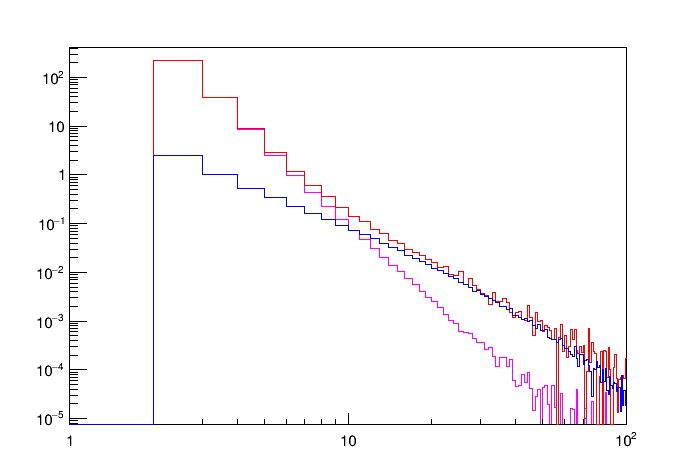

In [12]:
# Now time for yet another hybrid

HMBRecoPTHybrid3 = ROOT.TH1D("HMBRecoPTHybrid3", ";;", 100, 0, 100)
HDYRecoPTHybrid3 = ROOT.TH1D("HDYRecoPTHybrid3", ";;", 100, 0, 100)

TreeMBReco.Draw("trackPt >> HMBRecoPTHybrid3", f"EventWeight * ((trackPt >= {MinPT}) * (trackWeight) * (SubEventAllHF > 100000))", "")
TreeMBReco.Draw("3 >> HZCount", "EventWeight * (SubEventAllHF > 100000)", "")
HMBRecoPTHybrid3.Scale(1 / HZCount.GetBinContent(3))
DivideByBinWidth(HMBRecoPTHybrid2)
VMBHybrid2 = Integral(HMBRecoPTHybrid3)

TreeDYReco.Draw("trackPt >> HDYRecoPTHybrid3", f"ZWeight * EventWeight * ((trackPt >= {MinPT} && trackMuTagged == 0) * (trackWeight) * GoodRecoZ * (SubEventAllHF - SubEvent0HF > 100000))", "")
TreeDYReco.Draw("2 >> HZCount", "ZWeight * EventWeight * GoodRecoZ * (SubEventAllHF - SubEvent0HF > 100000)", "")
HDYRecoPTHybrid3.Scale(1 / HZCount.GetBinContent(2))
DivideByBinWidth(HDYRecoPTHybrid3)
VDYHybrid3 = Integral(HDYRecoPTHybrid3)

HMBRecoPTHybrid3.SetStats(0)

HDYRecoPTHybrid3.SetLineColor(ROOT.kRed)
HMBRecoPTHybrid3.SetLineColor(ROOT.kMagenta)

HMBRecoPTHybrid3.Draw("hist")
HDYRecoPTHybrid3.Draw("hist same")
HPPRecoPT.Draw("hist same")
Canvas.SetLogx()
Canvas.SetLogy()
Canvas.Draw()

print(f"Integral: MB = {Integral(HMBRecoPTHybrid3)}, DY = {Integral(HDYRecoPTHybrid3)}, PP = {Integral(HPPRecoPT)}")
print(f"First bin: MB = {HMBRecoPTHybrid3.GetBinContent(3)}, DY = {HDYRecoPTHybrid3.GetBinContent(3)}, PP = {HPPRecoPT.GetBinContent(3)}")

In [10]:
# Now let's look closer at the HF stuffs.  First we reproduce the SignalHF resolution from hydjet -- and also embedded

# TreeMBReco.Draw("SignalHF/SubEventAllHF:SubEventAllHF", "hiBin < 180", "colz", 100000)

GMBMean = ROOT.TGraph()
GMBSigma = ROOT.TGraph()
GMBResolution = ROOT.TGraph()
GDYMean = ROOT.TGraph()
GDYSigma = ROOT.TGraph()
GDYResolution = ROOT.TGraph()

for B in np.linspace(0, 175, 40):
    HistResponse = ROOT.TH1D(f"HHFResponse{int(B)}", "", 100, 0, 2)
    HistHF = ROOT.TH1D(f"HHF{int(B)}", "", 100, 0, 180000)
    TreeMBReco.Draw(f"SignalHF/SubEventAllHF>>HHFResponse{int(B)}", f"hiBin >= {B} && hiBin < {B+5}", "")
    TreeMBReco.Draw(f"SubEventAllHF>>HHF{int(B)}", f"hiBin >= {B} && hiBin < {B+5}", "")

    GMBMean.SetPoint(GMBMean.GetN(), HistHF.GetMean(), HistResponse.GetMean() - 1)
    GMBSigma.SetPoint(GMBSigma.GetN(), HistHF.GetMean(), HistResponse.GetRMS())
    GMBResolution.SetPoint(GMBResolution.GetN(), HistHF.GetMean(), HistResponse.GetRMS() / HistResponse.GetMean())

    TreeDYReco.Draw(f"(SignalHF-RecoHFShift)/(SubEventAllHF-SubEvent0HF)>>HHFResponse{int(B)}", f"hiBin >= {B} && hiBin < {B+5}", "")
    TreeDYReco.Draw(f"SubEventAllHF-SubEvent0HF>>HHF{int(B)}", f"hiBin >= {B} && hiBin < {B+5}", "")

    GDYMean.SetPoint(GDYMean.GetN(), HistHF.GetMean(), HistResponse.GetMean() - 1)
    GDYSigma.SetPoint(GDYSigma.GetN(), HistHF.GetMean(), HistResponse.GetRMS())
    GDYResolution.SetPoint(GDYResolution.GetN(), HistHF.GetMean(), HistResponse.GetRMS() / HistResponse.GetMean())


IOStream.flush timed out
IOStream.flush timed out


****************************************
Minimizer is Minuit / Migrad
Chi2                      =  3.67071e-06
NDf                       =           36
Edm                       =  2.10824e-07
NCalls                    =          102
p0                        =   0.00116573   +/-   0.00124691  
p1                        =      3.24164   +/-   0.0116944   
p2                        =      45.0066   +/-   0.958222    
p3                        =      109.824   +/-   123.082     
****************************************
Minimizer is Minuit / Migrad
Chi2                      =  1.32731e-06
NDf                       =           28
Edm                       =  1.02277e-06
NCalls                    =          143
p0                        =            0   +/-   0.000561068 
p1                        =      3.38089   +/-   0.0163418   
p2                        =      323.618   +/-   2.71827     
p3                        =      17937.8   +/-   142.553     


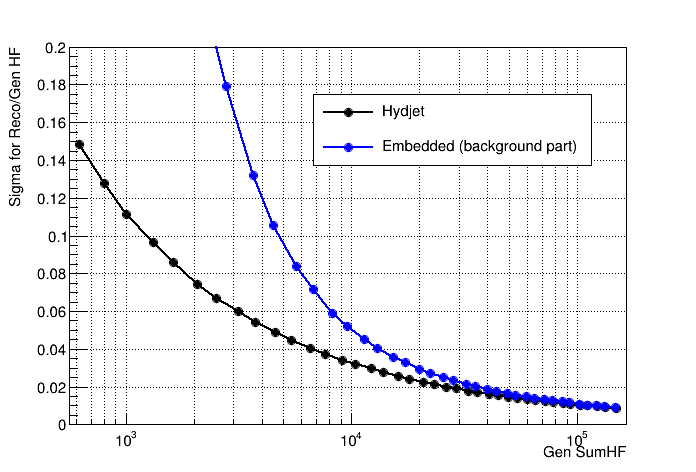

In [14]:
GMBSigma.SetMarkerStyle(20)
GMBSigma.SetLineWidth(2)
GDYSigma.SetMarkerStyle(20)
GDYSigma.SetMarkerColor(ROOT.kBlue)
GDYSigma.SetLineColor(ROOT.kBlue)
GDYSigma.SetLineWidth(2)

MBResolutionFunction = ROOT.TF1("MBResolutionFunction", "sqrt([0]*[0]+[1]*[1]/x+[2]*[2]/x/x+[3]*[3]/x/x/x)", 100, 180000)
MBResolutionFunction.SetParameters(0, 3.24, 44.9, 0.1)
MBResolutionFunction.SetLineColor(ROOT.kRed)
GMBSigma.Fit(MBResolutionFunction, "N", "", 100, 180000)

DYResolutionFunction = ROOT.TF1("DYResolutionFunction", "sqrt([0]*[0]+[1]*[1]/x+[2]*[2]/x/x+[3]*[3]/x/x/x)", 2000, 180000)
DYResolutionFunction.SetParameters(0, 4, 30, 25000)
DYResolutionFunction.SetLineColor(ROOT.kBlue + 1)
GDYSigma.Fit(DYResolutionFunction, "N", "", 2500, 180000)

GMBSigma.GetXaxis().SetTitle("Gen SumHF")
GMBSigma.GetYaxis().SetTitle("Sigma for Reco/Gen HF")
GMBSigma.GetXaxis().SetRangeUser(450, 180000)
GMBSigma.GetYaxis().SetRangeUser(0, 0.2)
GMBSigma.Draw("apl")
GDYSigma.Draw("pl")

# MBResolutionFunction.Draw("same")
# DYResolutionFunction.Draw("same")

Legend = ROOT.TLegend(0.45, 0.8, 0.85, 0.65)
Legend.SetTextFont(42)
Legend.SetTextSize(0.035)
Legend.AddEntry(GMBSigma, "Hydjet", "lp")
Legend.AddEntry(GDYSigma, "Embedded (background part)", "lp")
Legend.Draw()

Canvas.SetLogx(True)
Canvas.SetLogy(False)
Canvas.SetGridx(True)
Canvas.SetGridy(True)
Canvas.Draw()

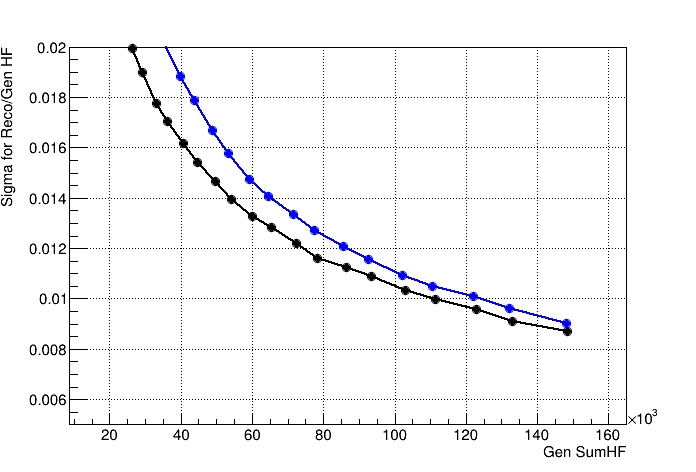

In [12]:
GMBSigma.GetXaxis().SetRangeUser(10000, 180000)
GMBSigma.GetYaxis().SetRangeUser(0.005, 0.02)
GMBSigma.Draw("apl")
GDYSigma.Draw("pl")

Canvas.SetLogx(False)
Canvas.SetLogy(False)
Canvas.SetGridx(True)
Canvas.SetGridy(True)
Canvas.Draw()

In [74]:
# HF stuffs in HF bins in preparation for resolution quantification

GMBMeanHF = ROOT.TGraph()
GMBSigmaHF = ROOT.TGraph()
GMBResolutionHF = ROOT.TGraph()
GDYMeanHF = ROOT.TGraph()
GDYSigmaHF = ROOT.TGraph()
GDYResolutionHF = ROOT.TGraph()

NBins = 50
Bins = np.exp(np.linspace(np.log(1000), np.log(180000), NBins + 1))

for i in range(0, NBins):
    HistResponse = ROOT.TH1D(f"HHFResponseB{i}", "", 100, 0, 2)
    
    TreeMBReco.Draw(f"SignalHF/SubEventAllHF>>HHFResponseB{i}", f"SubEventAllHF >= {Bins[i]} && SubEventAllHF < {Bins[i+1]}", "")
    
    GMBMeanHF.SetPoint(GMBMeanHF.GetN(), (Bins[i] + Bins[i+1]) / 2, HistResponse.GetMean() - 1)
    GMBSigmaHF.SetPoint(GMBSigmaHF.GetN(), (Bins[i] + Bins[i+1]) / 2, HistResponse.GetRMS())
    GMBResolutionHF.SetPoint(GMBResolutionHF.GetN(), (Bins[i] + Bins[i+1]) / 2, HistResponse.GetRMS() / HistResponse.GetMean())

    TreeDYReco.Draw(f"(SignalHF-RecoHFShift)/(SubEventAllHF-SubEvent0HF)>>HHFResponseB{i}", f"SubEventAllHF-SubEvent0HF >= {Bins[i]} && SubEventAllHF-SubEvent0HF < {Bins[i+1]}", "")
    
    GDYMeanHF.SetPoint(GDYMeanHF.GetN(), (Bins[i] + Bins[i+1]) / 2, HistResponse.GetMean() - 1)
    GDYSigmaHF.SetPoint(GDYSigmaHF.GetN(), (Bins[i] + Bins[i+1]) / 2, HistResponse.GetRMS())
    GDYResolutionHF.SetPoint(GDYResolutionHF.GetN(), (Bins[i] + Bins[i+1]) / 2, HistResponse.GetRMS() / HistResponse.GetMean())

****************************************
Minimizer is Minuit / Migrad
Chi2                      =  6.19255e-06
NDf                       =           46
Edm                       =  5.32494e-10
NCalls                    =           74
p0                        =            0   +/-   0.000518899 
p1                        =      3.21014   +/-   0.000363186 
p2                        =      27.8776   +/-   0.000364826 
p3                        =  -0.00162071   +/-   0.000364826 
****************************************
Minimizer is Minuit / Migrad
Chi2                      =  0.000430167
NDf                       =           37
Edm                       =  3.39025e-12
NCalls                    =           79
p0                        =            0   +/-   0.00179146  
p1                        =      4.37925   +/-   0.00481117  
p2                        =      7.10212   +/-   0.00482206  
p3                        =      18575.8   +/-   0.00482206  


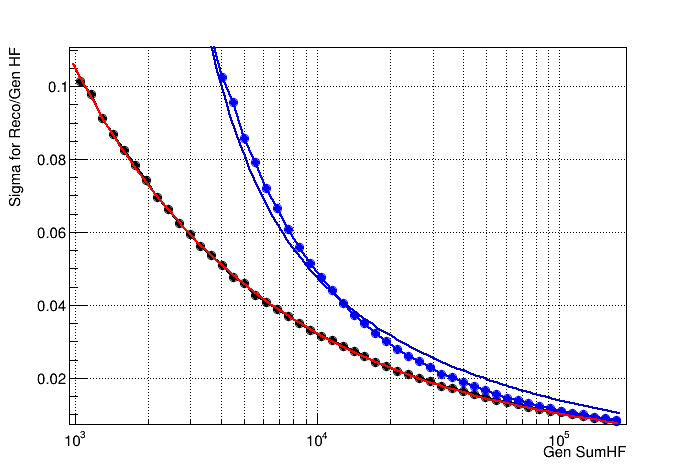

In [75]:
MBResolutionFunctionHF = ROOT.TF1("MBResolutionFunctionHF", "sqrt([0]*[0]+[1]*[1]/x+[2]*[2]/x/x+[3]*[3]/x/x/x)", 100, 180000)
MBResolutionFunctionHF.SetParameters(0, 3.24, 44.9, 0.1)
MBResolutionFunctionHF.SetLineColor(ROOT.kRed)
GMBSigmaHF.Fit(MBResolutionFunctionHF, "N", "", 100, 180000)

DYResolutionFunctionHF = ROOT.TF1("DYResolutionFunctionHF", "sqrt([0]*[0]+[1]*[1]/x+[2]*[2]/x/x+[3]*[3]/x/x/x)", 2000, 180000)
DYResolutionFunctionHF.SetParameters(0, 4, 30, 25000)
DYResolutionFunctionHF.SetLineColor(ROOT.kBlue + 1)
GDYSigmaHF.Fit(DYResolutionFunctionHF, "N", "", 2500, 180000)

GMBSigmaHF.SetMarkerStyle(20)
GMBSigmaHF.SetLineWidth(2)
GDYSigmaHF.SetMarkerStyle(20)
GDYSigmaHF.SetMarkerColor(ROOT.kBlue)
GDYSigmaHF.SetLineColor(ROOT.kBlue)
GDYSigmaHF.SetLineWidth(2)

GMBSigmaHF.GetXaxis().SetTitle("Gen SumHF")
GMBSigmaHF.GetYaxis().SetTitle("Sigma for Reco/Gen HF")
GMBSigmaHF.GetXaxis().SetRangeUser(450, 180000)
GMBSigmaHF.GetYaxis().SetRangeUser(0, 0.2)
GMBSigmaHF.Draw("apl")
GDYSigmaHF.Draw("pl")

MBResolutionFunctionHF.Draw("same")
# DYResolutionFunctionHF.Draw("same")

Canvas.SetLogx(True)
Canvas.SetLogy(False)
Canvas.SetGridx(True)
Canvas.SetGridy(True)
Canvas.Draw()

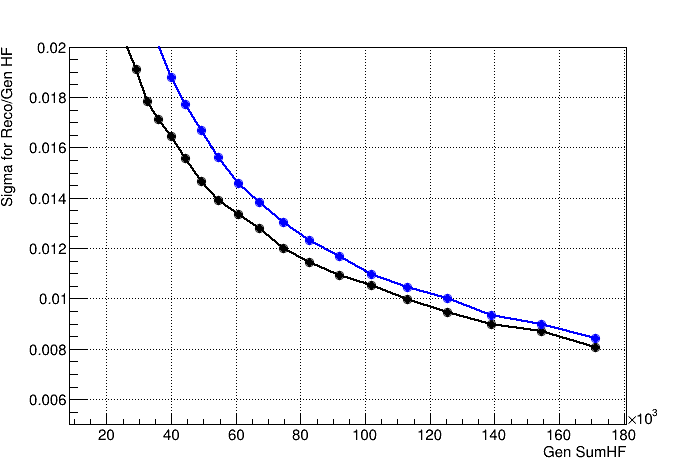

In [88]:
GMBSigmaHF.GetXaxis().SetRangeUser(10000, 180000)
GMBSigmaHF.GetYaxis().SetRangeUser(0.005, 0.02)
GMBSigmaHF.Draw("apl")
GDYSigmaHF.Draw("pl")

# MBResolutionFunctionHF.Draw("same")
# DYResolutionFunctionHF.Draw("same")

Canvas.SetLogx(False)
Canvas.SetLogy(False)
Canvas.SetGridx(True)
Canvas.SetGridy(True)
Canvas.Draw()

****************************************
Minimizer is Linear / Migrad
Chi2                      =   0.00335565
NDf                       =           45
p0                        =     -6.57294   +/-   2.74        
p1                        =       4.7148   +/-   1.18649     
p2                        =    -0.892209   +/-   0.190755    
p3                        =    0.0661044   +/-   0.0134978   
p4                        =  -0.00172263   +/-   0.000354788 


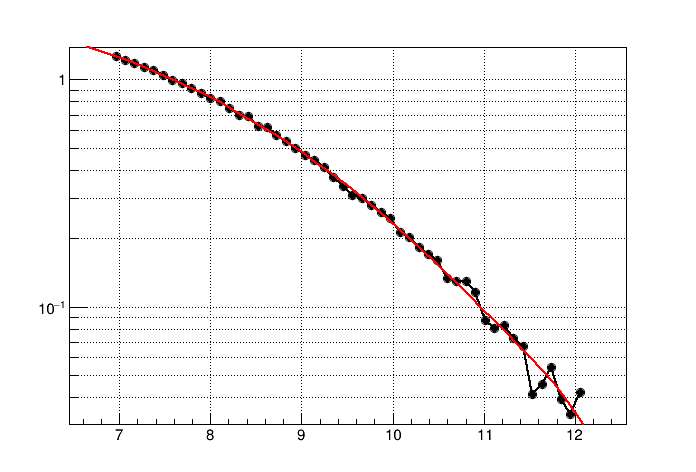

In [77]:
GSigmaHFRatio = ROOT.TGraph()

GSigmaHFRatio.SetMarkerStyle(20)
GSigmaHFRatio.SetLineWidth(2)

for i in range(GMBSigmaHF.GetN()):
    X = GMBSigmaHF.GetPointX(i)
    Y1 = GMBSigmaHF.GetPointY(i)
    Y2 = GDYSigmaHF.GetPointY(i)
    GSigmaHFRatio.SetPoint(GSigmaHFRatio.GetN(), np.log(X), np.log(Y2 / Y1))

FitFunction = ROOT.TF1("FitFunction", "pol4", 0, 13)
FitFunction.SetParameters(1, 1, 2, 5)
GSigmaHFRatio.Fit(FitFunction, "N")

GSigmaHFRatio.GetXaxis().SetTitle("ln(HF)")
GSigmaHFRatio.GetYaxis().SetTitle("ln(Resolution ratio)")

GSigmaHFRatio.Draw("apl")
FitFunction.Draw("same")
Canvas.SetLogx(False)
Canvas.SetLogy(True)
Canvas.Draw()

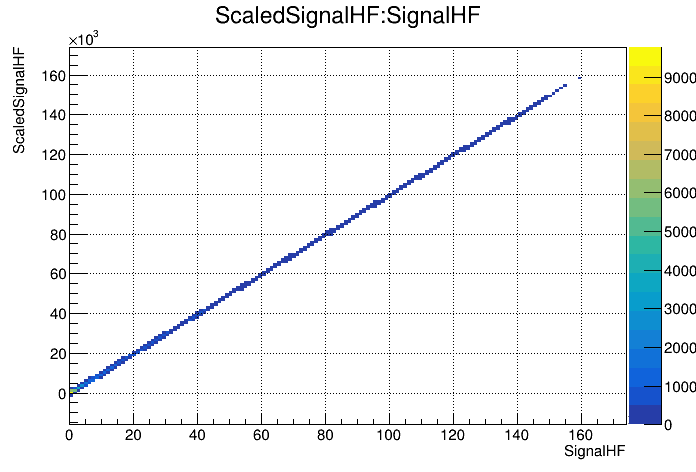

In [87]:
TreeMBReco.SetAlias("ResolutionScaleFactor", "exp(-6.57294+4.7148*log(SubEventAllHF)-0.892209*log(SubEventAllHF)*log(SubEventAllHF)+0.0661044*log(SubEventAllHF)*log(SubEventAllHF)*log(SubEventAllHF)-0.00172263*log(SubEventAllHF)*log(SubEventAllHF)*log(SubEventAllHF)*log(SubEventAllHF))")
TreeMBReco.SetAlias("ScaledSignalHF", "(SubEventAllHF+(SignalHF-SubEventAllHF)*ResolutionScaleFactor)")
TreeMBReco.Draw("ScaledSignalHF:SignalHF", "", "colz")
Canvas.SetLogy(False)
Canvas.Draw()

189.10097038842972
188.71007770838088
188.68308186500607
187.52742652876717
186.54976253872545
192.08951942837425
190.56616581827757
189.35992357746164
189.58493064158597
192.7639894448053
187.85694733676638
190.23572496912192
190.25190704313152
190.11692783289823
191.9248814822274
190.18734905813756
191.42754195028436
190.64166505617362
187.77589742236745
189.0170769664691
191.20949302675487
188.70511847021982
188.77874416591436
189.1369086669701
189.35691719307127
190.07155377973262
189.2239817553496
183.16842704060753
186.4837299763302
188.32428161681085
186.89116558462425
189.68835763797193
189.0586223458663
189.3702986008449
187.52629062621472
185.46096533580183
190.81200966799355
189.87241527119235
187.5331948331326
186.13461756903556
186.93916605945114
190.43395720218433
187.23179003718047
190.5817031917942
189.88186958499043
189.52186996444746
188.54735752545594
185.49231074866577
189.95533960602972
185.77466688625918
191.1793451307521
190.75370049167688
186.85675739181485
188.

Warning in <TROOT::Append>: Replacing existing TH1: HMBRecoPT030Partial (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HZCount (Potential memory leak).


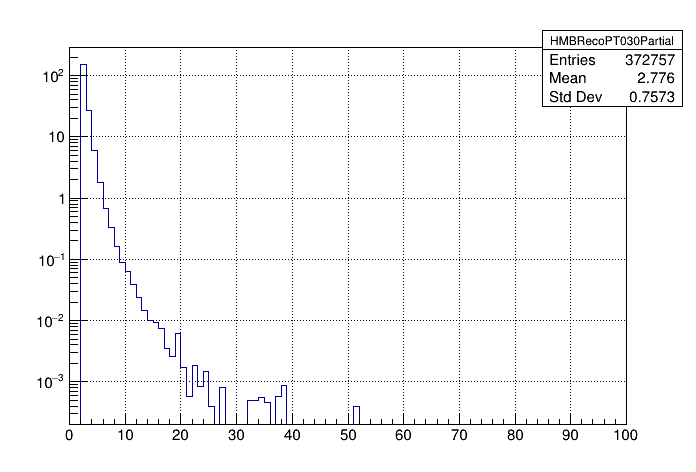

In [38]:
# Verifying if the discrepancy can be explained by fluctuations

HMBRecoPT030Partial  = ROOT.TH1D("HMBRecoPT030Partial", ";;", 100, 0, 100)
HZCount = ROOT.TH1D("HZCount", ";;", 10, 1, 11)

Batch = 10000
N = int(np.floor(TreeMBReco.GetEntries() / Batch))
V = np.zeros(N)
for i in range(0, N):
    # if i % 10 == 0:
    #     print(f'Processing {i}...')
    TreeMBReco.Draw("trackPt >> HMBRecoPT030Partial", f"EventWeight * ((trackPt >= {MinPT}) * (trackWeight)) * RecoWeight030", "", Batch, i * Batch)
    TreeMBReco.Draw("3 >> HZCount", "EventWeight * RecoWeight030", "", Batch, i * Batch)
    HMBRecoPT030Partial.Scale(1 / HZCount.GetBinContent(3))
    DivideByBinWidth(HMBRecoPT030Partial)
    V[i] = Integral(HMBRecoPT030Partial)
    print(V[i])

HMBRecoPT030Partial.Draw("hist")
Canvas.SetLogy()
Canvas.Draw()

mean = 188.970959407134, std. = 1.8550743859870418, corrected std. = 0.19811122212277077
corrected std. / mean = 0.0010483686104167163
fitted mu = 188.970959407134, sigma = 1.8550743859870418


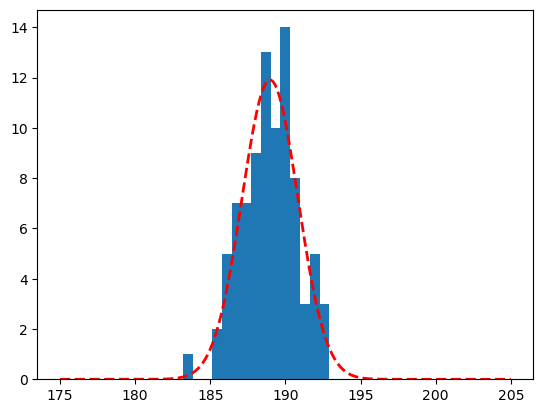

In [15]:
# Fluctuations summary plots

(mu, sigma) = norm.fit(V)

plt.hist(V, bins = 15)
y = norm.pdf(np.linspace(175, 205, 200), mu, sigma) * len(V) / math.pi * 2
l = plt.plot(np.linspace(175, 205, 200), y, 'r--', linewidth=2)

print(f'mean = {np.mean(V)}, std. = {np.std(V)}, corrected std. = {np.std(V) / np.sqrt(TreeMBReco.GetEntries() / Batch)}')
print(f'corrected std. / mean = {np.std(V) / np.sqrt(TreeMBReco.GetEntries() / Batch) / np.mean(V)}')
print(f'fitted mu = {mu}, sigma = {sigma}')

Integral: MB = 189.60570339225222, DY = 198.2198061658739, PP = 5.403203418664888
First bin: MB = 153.50715389816006, DY = 158.49014563523664, PP = 2.4451144412603836


Warning in <TROOT::Append>: Replacing existing TH1: HMBRecoPTC030Scale (Potential memory leak).


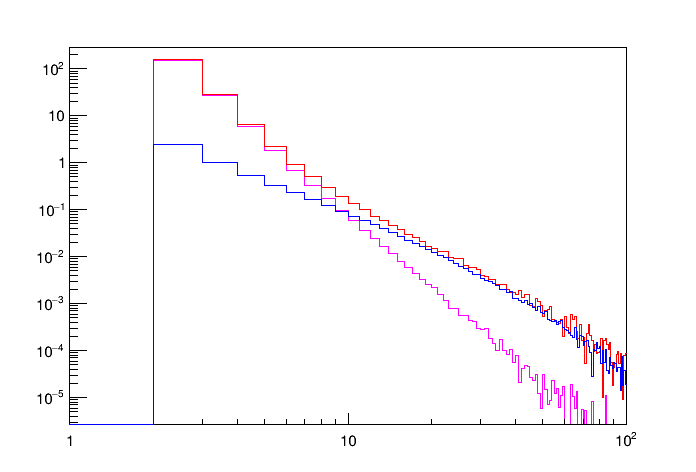

In [12]:
# MB Smearing test

HMBRecoPTC030Scale  = ROOT.TH1D("HMBRecoPTC030Scale", ";;", 100, 0, 100)

TreeMBReco.Draw("trackPt >> HMBRecoPTC030Scale", f"EventWeight * ((trackPt >= {MinPT}) * (trackWeight) * RecoWeight030Scale)", "")
TreeMBReco.Draw("3 >> HZCount", "EventWeight * RecoWeight030Scale", "")
HMBRecoPTC030Scale.Scale(1 / HZCount.GetBinContent(3))
DivideByBinWidth(HMBRecoPTC030Scale)
VMBC030Scale = Integral(HMBRecoPTC030Scale)

HMBRecoPTC030Scale.SetStats(0)

HDYRecoPTC030.SetLineColor(ROOT.kRed)
HMBRecoPTC030Scale.SetLineColor(ROOT.kMagenta)

HMBRecoPTC030Scale.Draw("hist")
HDYRecoPTC030.Draw("hist same")
HPPRecoPT.Draw("hist same")
Canvas.SetLogx()
Canvas.SetLogy()
Canvas.Draw()

print(f"Integral: MB = {Integral(HMBRecoPTC030Scale)}, DY = {Integral(HDYRecoPTC030)}, PP = {Integral(HPPRecoPT)}")
print(f"First bin: MB = {HMBRecoPTC030Scale.GetBinContent(3)}, DY = {HDYRecoPTC030.GetBinContent(3)}, PP = {HPPRecoPT.GetBinContent(3)}")

Warning in <TROOT::Append>: Replacing existing TH1: HDYShiftedRecoHF (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HMBPickedRecoHF (Potential memory leak).


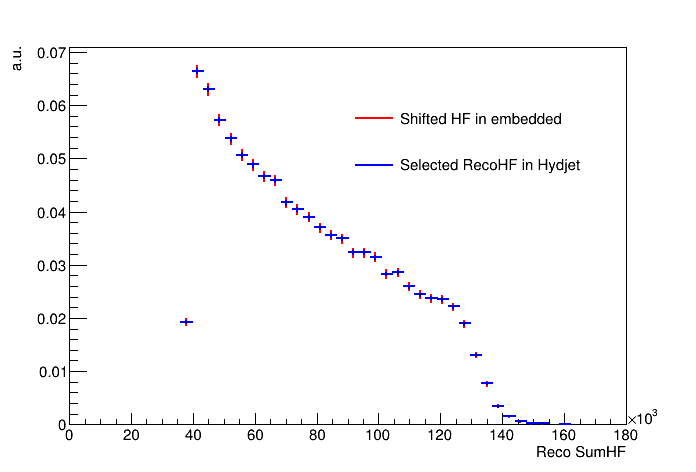

In [9]:
# Mapping back check: 0-30%, reco.  This should trivially match!

HDYShiftedRecoHF = ROOT.TH1D("HDYShiftedRecoHF", ";Reco SumHF;a.u.", 50, 0, 180000)
HMBPickedRecoHF = ROOT.TH1D("HMBPickedRecoHF", "", 50, 0, 180000)

TreeDYReco.Draw(f"SignalHF-RecoHFShift>>HDYShiftedRecoHF", f"EventWeight * ZWeight * (GoodRecoZ && (hiBin < 60))", "")
TreeMBReco.Draw(f"SignalHF>>HMBPickedRecoHF", f"EventWeight * RecoWeight030", "")

HDYShiftedRecoHF.SetLineColor(ROOT.kRed)
HDYShiftedRecoHF.SetLineWidth(2)
HMBPickedRecoHF.SetLineColor(ROOT.kBlue)
HMBPickedRecoHF.SetLineWidth(2)

HDYShiftedRecoHF.SetStats(0)

HDYShiftedRecoHF.DrawNormalized()
HMBPickedRecoHF.DrawNormalized("same")

Legend = ROOT.TLegend(0.5, 0.8, 0.8, 0.6)
Legend.SetTextFont(42)
Legend.SetTextSize(0.035)
Legend.SetBorderSize(0)
Legend.SetFillStyle(0)
Legend.AddEntry(HDYShiftedRecoHF, "Shifted HF in embedded", "l")
Legend.AddEntry(HMBPickedRecoHF, "Selected RecoHF in Hydjet", "l")
Legend.Draw()

Canvas.SetLogx(False)
Canvas.SetLogy(False)
Canvas.Draw()



Warning in <TROOT::Append>: Replacing existing TH1: HDYTrueGenHF (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HMBPickedGenHF (Potential memory leak).


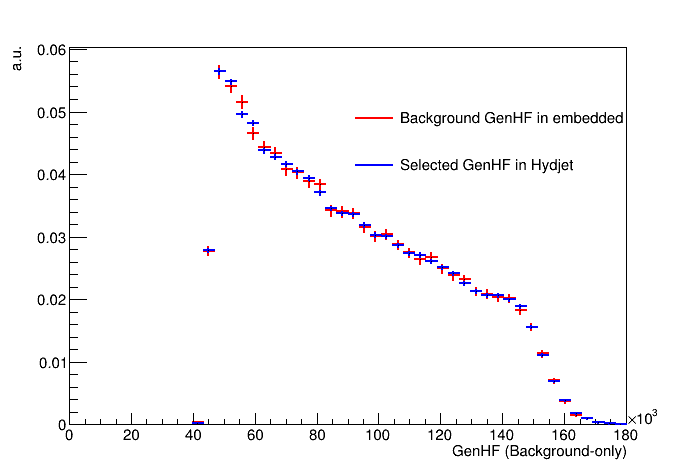

In [10]:
# Mapping back check: 0-30%

HDYTrueGenHF = ROOT.TH1D("HDYTrueGenHF", ";GenHF (Background-only);a.u.", 50, 0, 180000)
HMBPickedGenHF = ROOT.TH1D("HMBPickedGenHF", "", 50, 0, 180000)

TreeDYReco.Draw(f"SubEventAllHF - SubEvent0HF>>HDYTrueGenHF", f"EventWeight * ZWeight * (GoodRecoZ && (hiBin < 60))", "")
TreeMBReco.Draw(f"SubEventAllHF>>HMBPickedGenHF", f"EventWeight * RecoWeight030", "")

HDYTrueGenHF.SetLineColor(ROOT.kRed)
HDYTrueGenHF.SetLineWidth(2)
HMBPickedGenHF.SetLineColor(ROOT.kBlue)
HMBPickedGenHF.SetLineWidth(2)

HDYTrueGenHF.SetStats(0)

HDYTrueGenHF.DrawNormalized()
HMBPickedGenHF.DrawNormalized("same")

Legend = ROOT.TLegend(0.5, 0.8, 0.8, 0.6)
Legend.SetTextFont(42)
Legend.SetTextSize(0.035)
Legend.SetBorderSize(0)
Legend.SetFillStyle(0)
Legend.AddEntry(HDYTrueGenHF, "Background GenHF in embedded", "l")
Legend.AddEntry(HMBPickedGenHF, "Selected GenHF in Hydjet", "l")
Legend.Draw()

Canvas.SetLogx(False)
Canvas.SetLogy(False)
Canvas.Draw()



In [ ]:
# Small bin test

In [ ]:
# MB centrality test

In [42]:
TreePPReco.Draw("trackPt >> HPPRecoPT", f"ZWeight * EventWeight * ((trackPt >= {MinPT} && trackMuTagged == 0 && NVertex == 1) * (trackWeight) * GoodRecoZ)", "")
TreePPReco.Draw("1 >> HZCount", "ZWeight * EventWeight * GoodRecoZ * (NVertex == 1)", "")

90331

In [ ]:
TreePPReco.Scan("ZWeight * EventWeight * GoodRecoZ * (NVertex == 1)", "", 100)

In [ ]:
TranscribeRecoWeightOld("RecoWeight_Centrality030.root")
TreeMBReco.SetAlias("RecoWeight030Prime", '(0+15.921855123527049*(SignalHF>=36720.0&&SignalHF<37440.0)+171.57204348676422*(SignalHF>=37440.0&&SignalHF<38160.0)+873.5951693451168*(SignalHF>=38160.0&&SignalHF<38880.0)+2071.790395556571*(SignalHF>=38880.0&&SignalHF<39600.0)+(2.35789e+03-4.80389e-03*SignalHF)*(SignalHF>=39600.0))')

In [ ]:
TreeMBReco.Draw("SignalHF")
TreeDYReco.Draw("SignalHF", "EventWeight * (zPt[0] > 20 && zY[0] < 2.4 && zY[0] > -2.4 && zMass[0] > 60 && zMass[0] < 120)")
Canvas.SetLogy(True)
Canvas.Draw()

In [ ]:
TreeMBReco.GetEntries()

In [ ]:
TreeMBReco.Draw("RecoWeight030:SignalHF")
Canvas.Draw()

In [ ]:
File = ROOT.TFile("RecoWeight_Centrality030.root")
Hist = File.Get("HRatio")
Hist.Draw()
Canvas.SetLogy(False)
Canvas.Draw()


In [ ]:
HPPRecoPT  = ROOT.TH1D("HPPRecoPT", ";;", 100, 0, 100)
HDYRecoPTHybrid  = ROOT.TH1D("HDYRecoPTHybrid", ";;", 100, 0, 100)
HMBRecoPTHybrid  = ROOT.TH1D("HMBRecoPTHybrid", ";;", 100, 0, 100)
HZCount = ROOT.TH1D("HZCount", ";;", 10, 1, 11)

TreePPReco.Draw("trackPt >> HPPRecoPT", f"EventWeight * ((trackPt >= {MinPT}) * (trackWeight)) * GoodRecoZ", "")
TreePPReco.Draw("1 >> HZCount", f"EventWeight * GoodRecoZ", "")
HPPRecoPT.Scale(1 / HZCount.GetBinContent(1))
DivideByBinWidth(HPPRecoPT)
VPP = Integral(HPPRecoPT)

TreeDYReco.Draw("trackPt >> HDYRecoPTHybrid", f"EventWeight * ((trackPt >= {MinPT}) * (trackWeight)) * GoodRecoZ * (SubEventAllHF - SubEvent0HF > 40000)", "")
TreeDYReco.Draw("2 >> HZCount", f"EventWeight * GoodRecoZ * (SubEventAllHF - SubEvent0HF > 40000)", "")
HDYRecoPTHybrid.Scale(1 / HZCount.GetBinContent(2))
DivideByBinWidth(HDYRecoPTHybrid)
VTrue = Integral(HDYRecoPTHybrid)

Batch = 10000
N = int(np.floor(TreeMBReco.GetEntries() / Batch))
V = np.zeros(N)
for i in range(0, N):
    # if i % 10 == 0:
    #     print(f'Processing {i}...')
    TreeMBReco.Draw("trackPt >> HMBRecoPTHybrid", f"EventWeight * ((trackPt >= {MinPT}) * (trackWeight)) * (SubEventAllHF > 40000)", "", Batch, i * Batch)
    TreeMBReco.Draw("3 >> HZCount", "EventWeight * (SubEventAllHF > 40000)", "", Batch, i * Batch)
    HMBRecoPTHybrid.Scale(1 / HZCount.GetBinContent(3))
    DivideByBinWidth(HMBRecoPTHybrid)
    V[i] = Integral(HMBRecoPTHybrid)
    # print(V[i])

HMBRecoPTHybrid.Draw("hist")
Canvas.SetLogy()
Canvas.Draw()

In [ ]:
(mu, sigma) = norm.fit(V)

plt.hist(V, bins = 15)
y = norm.pdf(np.linspace(175, 205, 200), mu, sigma) * len(V) / math.pi * 2
l = plt.plot(np.linspace(175, 205, 200), y, 'r--', linewidth=2)

print(f'mean = {np.mean(V)}, std. = {np.std(V)}, corrected std. = {np.std(V) / np.sqrt(TreeMBReco.GetEntries() / Batch)}')
print(f'corrected std. / mean = {np.std(V) / np.sqrt(TreeMBReco.GetEntries() / Batch) / np.mean(V)}')
print(f'fitted mu = {mu}, sigma = {sigma}')
print(f'true target = {VTrue} - {VPP} = {VTrue - VPP}')

In [ ]:
P1 = [9.7256347, -3.844, 4.4439997, -7.75]
P2 = [17.653234, -6.703, 8.5159997, -13.935]

P1[0] = np.sqrt(P1[1]**2 + P1[2]**2 + P1[3]**2)
P2[0] = np.sqrt(P2[1]**2 + P2[2]**2 + P2[3]**2)

P = P1 + P2

Dot = P1[1] * P2[1] + P1[2] * P2[2] + P1[3] * P2[3]
Angle = math.acos(Dot / P1[0] / P2[0])
Mass = np.sqrt(P[0]**2 - P[1]**2 - P[2]**2 - P[3]**2)

print(Angle)
print(Mass)